In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [59]:
import datetime as dt

ImportError: cannot import name 'strptime' from 'datetime' (/Users/dagneycooke/anaconda3/envs/PythonData/lib/python3.7/datetime.py)

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# get column names for measurement

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
    
# get column names for station   
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [202]:
# find last date a measurement was taken and then find the date a year before it
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

# get date out of query
last_date = last_date_query[0][0]

# convert string to date and calculate one yar ago
one_year_ago = dt.datetime.strptime(last_date,'%Y-%m-%d').date() - dt.timedelta(days=365)

# query Measurement date and prcp, ignoring dates where there's no value for prcp 
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.prcp != 0).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date.asc()).all()
dates = []
prcp = []
dates = [result[0] for result in results]
prcp = [result[1] for result in results]
df = pd.DataFrame(prcp,columns=["Precipitation"],index=[dates])


#df.plot(df.index,df["Precipitation"],kind='bar')
    
# fig, ax = plt.subplots()
# ax.bar(dates,prcp)
# ax.set_xlabel("dates")
# ax.set_xticklabels([])
# ax.set_ylabel("precipitation")
# ax.set_yticklabels(prcp[::-1])
# ax.set_title("Precipitation")
# fig.tight_layout()
# plt.show()

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [121]:
print(df.index.values)

[('2016-08-24',) ('2016-08-24',) ('2016-08-24',) ... ('2017-08-22',)
 ('2017-08-23',) ('2017-08-23',)]


In [203]:
df.describe()

,Precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [176]:
# Design a query to show how many stations are available in this dataset?
station_types = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are {station_types} stations')

There are 9 stations


In [188]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# get list of stations
station_types = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(station_types[0][0])

USC00519281


In [199]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_types[0][0]).all()
station_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_types[0][0]).all()
station_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_types[0][0]).all()

print(f'The lowest temperature recorded is {station_min[0][0]}')
print(f'The highest temperature recorded is {station_max[0][0]}')
print(f'The average temperature is {station_avg[0][0]}')

The lowest temperature recorded is 54.0
The highest temperature recorded is 85.0
The average temperature is 71.66378066378067


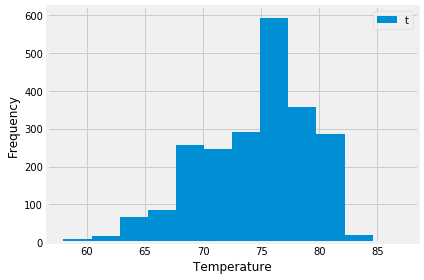

In [215]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.tobs != 0).\
    filter(Measurement.date >= one_year_ago).all()
tobs = []
tobs = [result[1] for result in results]
#print(len(tobs))


plt.hist(tobs,bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(labels="tobs")
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [217]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


[(67.0, 73.92105263157895, 83.0)]
67.0


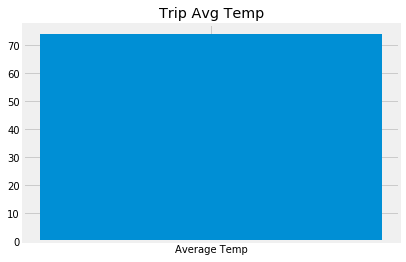

In [232]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-04-16'
end_date = '2017-04-27'

temp_list = []
temp_list = calc_temps(start_date,end_date)
print(temp_list)


67.0


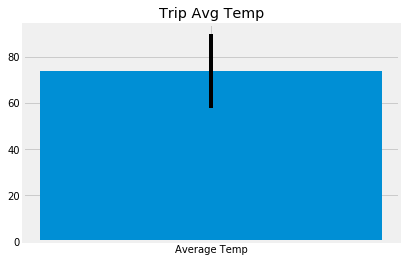

In [234]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar("Average Temp",temp_list[0][1],yerr=(temp_list[0][2]-temp_list[0][0]))
plt.title("Trip Avg Temp")
#plt.errorbar()
print(temp_list[0][0])

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
